## Image segmentation with Unet using pytorch

https://www.coursera.org/learn/deep-learning-with-pytorch-image-segmentation

In [309]:
# !pip install segmentation-models-pytorch
# !pip install albumentations
# !pip install --upgrade opencv-contrib-python

### Download image dataset

In [310]:
dir_path = '../data/3_09/'
data_path = os.path.join(dir_path, "Human-Segmentation-Dataset-master")
# !git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git {data_path}

### Setup configuration

In [311]:
import os
import torch 
import cv2 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
import helper

In [312]:
# Path to the training dataset CSV file 
csv_file = os.path.join(data_path, "train.csv")

# Device to use for model training 
device = 'cuda'

# Number of iterations over the entire dataset for training
epochs = 25

# Learning rate for the optimizer, which controls the step size during weight updates
learning_rate = 0.003

# Image size for input images to the model
image_size = 320

# Number of samples processed together in each iteration
batch_size = 16

# Pre-trained encoder model to use (EfficientNet-B0 from the timm library)
encoder = 'timm-efficientnet-b0'

# Source of the pre-trained weights (ImageNet weights)
weights = 'imagenet'

### Visualize the data

* Masks column contains the 'ground through' (segmentations) 
* Images column contains the original images

In [313]:
df = pd.read_csv(csv_file)
df = df.apply(lambda col: col.map(lambda x: os.path.normpath(os.path.join(dir_path, x)) )) 
df.head(10)

,masks,images
0,..\data\3_09\Human-Segmentation-Dataset-master...,..\data\3_09\Human-Segmentation-Dataset-master...
1,..\data\3_09\Human-Segmentation-Dataset-master...,..\data\3_09\Human-Segmentation-Dataset-master...
2,..\data\3_09\Human-Segmentation-Dataset-master...,..\data\3_09\Human-Segmentation-Dataset-master...
3,..\data\3_09\Human-Segmentation-Dataset-master...,..\data\3_09\Human-Segmentation-Dataset-master...
4,..\data\3_09\Human-Segmentation-Dataset-master...,..\data\3_09\Human-Segmentation-Dataset-master...
5,..\data\3_09\Human-Segmentation-Dataset-master...,..\data\3_09\Human-Segmentation-Dataset-master...
6,..\data\3_09\Human-Segmentation-Dataset-master...,..\data\3_09\Human-Segmentation-Dataset-master...
7,..\data\3_09\Human-Segmentation-Dataset-master...,..\data\3_09\Human-Segmentation-Dataset-master...
8,..\data\3_09\Human-Segmentation-Dataset-master...,..\data\3_09\Human-Segmentation-Dataset-master...
9,..\data\3_09\Human-Segmentation-Dataset-master...,..\data\3_09\Human-Segmentation-Dataset-master...


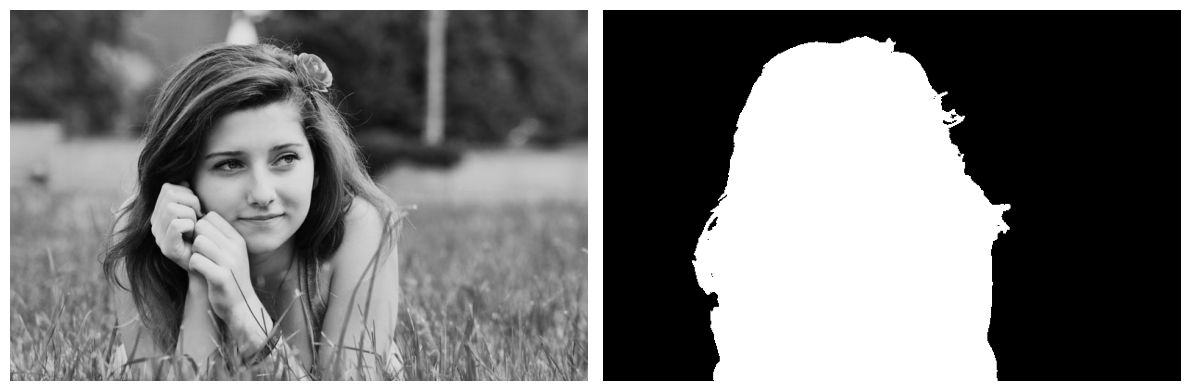

In [314]:
row = df.iloc[3]   
mask = cv2.imread(row.masks, cv2.IMREAD_GRAYSCALE) 
image = cv2.imread(row.images)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].axis('off') 
axes[1].imshow(mask, cmap='gray')
axes[1].axis('off')
plt.tight_layout()
plt.show()

### Split the data into trainin and testing sets

In [315]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"size of trainset: {len(train_df)}")
print(f"size of testset: {len(test_df)}") 

size of trainset: 232
size of testset: 58


### Apply augmentation on images
* For lassification tasks augmentaion augmentation is not applied on labels
* But for segmentation tasks augmentation is applied to masks
* albumentation documentation : https://albumentations.ai/docs/

In [316]:
def get_train_augmentations():
    return A.Compose([        
        A.Resize(image_size, image_size),        # Resize image to the specified dimensions        
        A.HorizontalFlip(p=0.5),                 # Random horizontal flip with 50% probability        
        A.VerticalFlip(p=0.5)                    # Random vertical flip with 50% probability
    ])

def get_test_augmentations():
    return A.Compose([
        A.Resize(image_size, image_size)         # Resize image to the specified dimensions  
    ])
    

### Create custom Dataset

In [317]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations = augmentations
 
  def __len__(self):
    return len(self.df)
 
  def __getitem__(self, index):
    row = self.df.iloc[index] 

    mask = cv2.imread(row.masks, cv2.IMREAD_GRAYSCALE)     
    mask = np.expand_dims(mask, axis = -1)               # Add channel dimension: (h, w, c)
      
    image = cv2.imread(row.images)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if image.shape != mask.shape:            
            image = cv2.resize(image, (mask.shape[1], mask.shape[0]))      # Resize or crop iamge to match mask dimensions 

    if self.augmentations:  
        data = self.augmentations(image=image, mask=mask)      # image and mask params are handled to __call__ method of the A.Compose class
        image = data['image']
        mask = data['mask']

    # (h, w, c) -> (c, h, w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    # Convert from numpy to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) /255.0)

    return image, mask      

In [318]:
trainset = SegmentationDataset(train_df, get_train_augmentations())
testset = SegmentationDataset(test_df, get_test_augmentations())

print(f"size of trainset: {len(trainset)}")
print(f"size of testset: {len(testset)}") 

size of trainset: 232
size of testset: 58


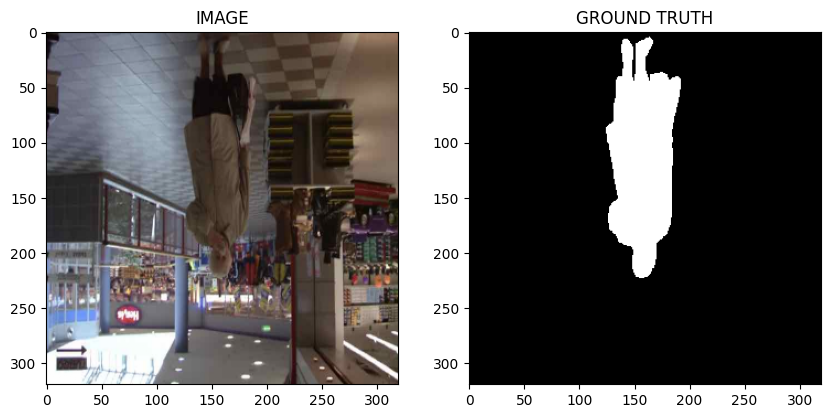

In [321]:
image, mask = trainset[8]
helper.show_image(image, mask)

### Load dataset into batches

In [322]:
# load dataset with dataloader
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Extract a single batch (image, mask) from the trainloader
image, mask = next(iter(trainloader))

print(f"size of trainloader: {len(trainloader)}")
print(f"size of testloader: {len(testloader)}") 
print(f"image shape: {image.shape}")
print(f"mask shape: {mask.shape}")

size of trainloader: 15
size of testloader: 4
image shape: torch.Size([16, 3, 320, 320])
mask shape: torch.Size([16, 1, 320, 320])


### Define a custom segmentation model 

In [323]:
class SegmentationModel(nn.Module): 
    def __init__(self): 
        super(SegmentationModel, self).__init__()

        # Define the UNet model  
        self.arc = smp.Unet(
            encoder_name=encoder,       # Encoder backbone: 'timm-efficientnet-b0'
            encoder_weights=weights,    # Pre-trained weights from 'imagenet'
            in_channels=3,              # Number of input channels (3 for RGB images)
            classes=1,                  # Number of output channels (1 for binary segmentation)
            activation=None             # No activation function applied at the output 
        )

    # Forward pass through the model
    def forward(self, images, mask=None):        
        logits = self.arc(images)      # Feed the image data into the model for processing

        # If a ground truth mask is provided, calculate and return the losses
        if mask is not None:            
            loss1 = DiceLoss(mode="binary")(logits, mask)    # Calculate Dice Loss measuring overlap b/w predicted and actual segmentation 
            loss2 = nn.BCEWithLogitsLoss()(logits, mask)     # Calculate the Binary Cross-Entropy Loss (with logits)
            return logits, loss1 + loss2                     
            
        # If no mask is provided, just return the logits (for inference)
        return logits

# logits = raw, unnormalized outputs produced by the final layer of the neural network before applying any activation function        

In [324]:
model = SegmentationModel()
model.to(device)  # 'cuda'

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

### Create Train and Validation Function

In [325]:
def train_fn(model, dataloader, optimizer):
  model.train()       # Set the model to training mode
  total_loss = 0.0    # Store the accumulated training loss over all batches
    
  for images, masks in tqdm(dataloader):      # Iterare over batches of images and corresponding masks
    images = images.to(device)                # Move images and masks to the GPU 
    masks = masks.to(device)  
    optimizer.zero_grad()                     # Clear the gradients of all model parameters that will be updated by the optimizer
    logits, loss = model(images, masks)       # Forward pass: get predictions (logits) and compute the loss based on the current parameters
    loss.backward()                           # Backward pass: compute gradients of the loss with respect to the model parameters using the chain rule
    optimizer.step()                          # Update model parameters (weights and biases) based on the gradients calculated
    total_loss += loss.item()                 # Accumulate the loss for each batch
   
  return total_loss / len(dataloader)         # Calculate and return the average training loss over all batches 

In [326]:
def eval_fn(model, dataloader):
  model.eval()        # Set the model in evaluation mode 
  total_loss = 0.0    # Store the accumulated evaluation loss over all batches

  with torch.no_grad():                        # No gradient computation is needed during evaluation
    for images, masks in tqdm(dataloader):     # Iterare over batches of images and corresponding masks | tqdm shows a progress bar
      images = images.to(device)               # Move images and masks to the GPU  
      masks = masks.to(device)   
      logits, loss = model(images, masks)      # Forward pass: get logits (model output) and loss
      total_loss += loss.item()                # Accumulate the loss for each batch
        
  return total_loss / len(dataloader)          # Return the average loss over all batches

### Train Model

In [327]:
# Optimizer adjusts model parameters during training to minimize the loss function
# With Adam optimizer the learning rate is adaptively adjusted for each parameter. 
# Parameters with larger gradients get smaller updates, and parameters with smaller gradients get larger updates.

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [328]:
best_valid_loss = np.inf                                    # Initialize best validation error as infinity                         
model_path = os.path.join(dir_path, "best_model.pth")

for epoch in range(epochs):   
  train_loss = train_fn(model, trainloader, optimizer)      # Train the model for one epoch
  valid_loss = eval_fn(model, testloader)                   # Evaluate the model on the test set after training
 
  if valid_loss < best_valid_loss:                          # Save the model if the current loss is lower than the previous best 
    torch.save(model.state_dict(), model_path)
    print("Model saved in", model_path)
    best_valid_loss = valid_loss

  print(f"EPOCH : {epoch+1} | Train Loss : {train_loss} | Valid Loss : {valid_loss}")

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.10it/s]


Model saved in ../data/3_09/best_model.pth
EPOCH : 1 | Train Loss : 0.758962482213974 | Valid Loss : 1.4376886487007141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12it/s]


Model saved in ../data/3_09/best_model.pth
EPOCH : 2 | Train Loss : 0.4097691317399343 | Valid Loss : 0.5866234973073006


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98it/s]


Model saved in ../data/3_09/best_model.pth
EPOCH : 3 | Train Loss : 0.3309830884138743 | Valid Loss : 0.2723705358803272


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


Model saved in ../data/3_09/best_model.pth
EPOCH : 4 | Train Loss : 0.33037056028842926 | Valid Loss : 0.2554468959569931


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06it/s]


Model saved in ../data/3_09/best_model.pth
EPOCH : 5 | Train Loss : 0.23320639431476592 | Valid Loss : 0.2436135709285736


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00it/s]


EPOCH : 6 | Train Loss : 0.2282502084970474 | Valid Loss : 0.3339743800461292


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


Model saved in ../data/3_09/best_model.pth
EPOCH : 7 | Train Loss : 0.21700550317764283 | Valid Loss : 0.19734372571110725


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.63it/s]


Model saved in ../data/3_09/best_model.pth
EPOCH : 8 | Train Loss : 0.19580419063568116 | Valid Loss : 0.19632607325911522


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


EPOCH : 9 | Train Loss : 0.21105366547902424 | Valid Loss : 0.23597955331206322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00it/s]


EPOCH : 10 | Train Loss : 0.1761295144756635 | Valid Loss : 0.20998303592205048


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


EPOCH : 11 | Train Loss : 0.16438595602909725 | Valid Loss : 0.2088598757982254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


EPOCH : 12 | Train Loss : 0.1502228284875552 | Valid Loss : 0.20523641631007195


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


EPOCH : 13 | Train Loss : 0.16266304900248846 | Valid Loss : 0.3772003874182701


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98it/s]


EPOCH : 14 | Train Loss : 0.16967319945494333 | Valid Loss : 0.20365077629685402


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.96it/s]


Model saved in ../data/3_09/best_model.pth
EPOCH : 15 | Train Loss : 0.129874083896478 | Valid Loss : 0.1737594325095415


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90it/s]


Model saved in ../data/3_09/best_model.pth
EPOCH : 16 | Train Loss : 0.11422626376152038 | Valid Loss : 0.1602286882698536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


EPOCH : 17 | Train Loss : 0.11533996164798736 | Valid Loss : 0.18743306398391724


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.92it/s]


EPOCH : 18 | Train Loss : 0.11030288139979044 | Valid Loss : 0.18688541650772095


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


EPOCH : 19 | Train Loss : 0.12818819681803387 | Valid Loss : 0.19187738001346588


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


EPOCH : 20 | Train Loss : 0.13401817282040915 | Valid Loss : 0.22231072932481766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


EPOCH : 21 | Train Loss : 0.16430318305889766 | Valid Loss : 0.253975173458457


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.84it/s]


EPOCH : 22 | Train Loss : 0.18247651706139248 | Valid Loss : 0.25160882249474525


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


EPOCH : 23 | Train Loss : 0.25229061394929886 | Valid Loss : 0.24525293335318565


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


EPOCH : 24 | Train Loss : 0.20749929994344712 | Valid Loss : 0.21695519611239433


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90it/s]

EPOCH : 25 | Train Loss : 0.18587201535701753 | Valid Loss : 0.18823906034231186


### Inference

In [329]:
def inference(index): 
  model.load_state_dict(torch.load(f'{dir_path}/best_model.pth'))   # Load the model weights from best_model.pth 
  image, mask = testset[index]                                      # Fetch a test image/mask pair from the test set                                                 
                                                                    # Run the image through the model
  logits_mask = model(image.to(device).unsqueeze(0))                # Add batch dimension as the model expects a batch: (C, H, W) -> (1, C, H, W)
  pred_mask = torch.sigmoid(logits_mask)                            # Apply sigmoid activation function to the model output to get probabilities for the mask
  pred_mask = (pred_mask > 0.5)*1.0                                 # Convert the probability values to binary (0 or 1) using a threshold of 0.5

  # Display the original image, the ground truth mask, and the predicted mask 
  # The pred_mask is moved back to CPU and squeezed to remove the extra batch dimension: (1, C, H, W) -> (C, H, W)     
  return helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

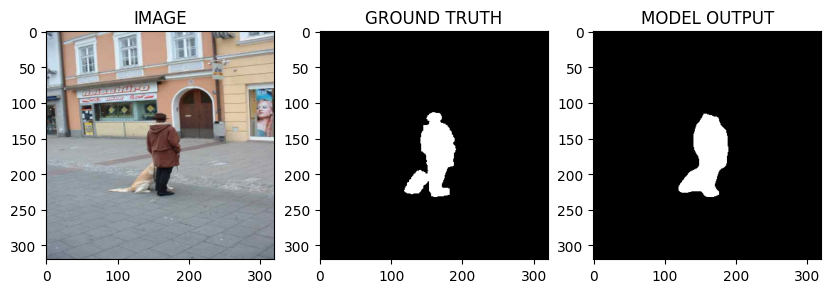

In [334]:
inference(index=10)   # Perform inference on an image

### TODO: Attempt training with different learning_rate and batch_size